In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
import matplotlib.pyplot as plt
from sklearn.utils import resample


In [3]:
df = pd.read_csv("data/diabetic_data.csv")

# replacing ? with NaN
df = df.replace('?', np.nan)

df = df[df['readmitted'].isin(['<30', '>30', "NO"])]

# delete columns with more than 40% missing data
missing_threshold = 0.4
df = df.loc[:, df.isnull().mean() < missing_threshold]

# delete rows with missing values
df = df.dropna()

# Removing id and nbr
df = df.drop(['encounter_id', 'patient_nbr'], axis=1)

# Getting all categorical columns
categorical_cols = df.select_dtypes(include='object').columns.drop('readmitted')

# Doing one-hot encoding for the categorical columns, basically converting them to 0 or 1
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Setting readmitted to be 0, 1, or 2 based on class labels
df['readmitted'] = df['readmitted'].map({
    "NO": 0,
    "<30": 1,
    ">30": 2
})

# Keeping the original dataframe as well
original_df = df

print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (59129, 2163)


In [138]:
# Using random oversampling to adjust the data prior to working with it
print("Class distribution before balancing:")
print(df['readmitted'].value_counts())

# Getting index and number of the majority class in our dataset (Not readmitted)
majority = df['readmitted'].value_counts().idxmax()
majority_size = df['readmitted'].value_counts().max()

first_class = df[df["readmitted"] == 0]
second_class = df[df["readmitted"] == 1]
third_class = df[df["readmitted"] == 2]

# Using oversampling for both the minority classes
oversample_second_class = resample(second_class, replace=True, n_samples=majority_size, random_state=13)
oversample_third_class = resample(third_class, replace=True, n_samples=majority_size, random_state=13)

# Putting back the classes in to one dataframe and shuffling it
entire_dataframe = pd.concat([first_class, oversample_second_class, oversample_third_class])
entire_dataframe = entire_dataframe.sample(frac=1, random_state=13).reset_index(drop=True)
df = entire_dataframe

print("\nClass distribution after balancing:")
print(df['readmitted'].value_counts())

Class distribution before balancing:
readmitted
0    31457
2    21158
1     6514
Name: count, dtype: int64

Class distribution after balancing:
readmitted
1    31457
2    31457
0    31457
Name: count, dtype: int64


In [152]:


X = df.drop("readmitted", axis=1)
y = df["readmitted"]
y

20446     0
20737     0
20824     0
21083     0
23668     1
         ..
101760    2
101761    2
101762    0
101763    0
101764    0
Name: readmitted, Length: 59129, dtype: int64

In [153]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=13)

In [154]:
from itertools import product
def tune_random_forest(X_train, y_train, X_val, y_val):
    n_estimators_range = [100, 500]
    max_depth_range = [20, 50]
    max_features_range=["sqrt", "log2"]
    min_samples_split_range=[5, 10, 20]
    class_weight_options=["balanced"]

    best_val_accuracy = 0
    best_params = {}
    results = []

    param_combinations = list(product(n_estimators_range, max_depth_range, max_features_range, min_samples_split_range, class_weight_options))

    print(f"Testing {len(param_combinations)} Paramater combinations")
    count = 1

    for i, (n, dr, mfr, mspr, cw) in enumerate(param_combinations):
        print(f"testing {i}/{len(param_combinations)}")
        rf = RandomForestClassifier(
                n_estimators=n,
                max_depth=dr,
                max_features=mfr,
                min_samples_split=mspr,
                class_weight=cw,
                random_state=13
        )

        rf.fit(X_train, y_train)

        # Make preds
        y_pred_train = rf.predict(X_train)
        y_pred_val = rf.predict(X_val)

        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_pred_train)
        val_accuracy = accuracy_score(y_val, y_pred_val)  

        result = {
                'n_estimators': n,
                'max_depth': dr,
                'max_features': mfr,
                'min_samples_split': mspr,
                'class_weight': cw,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy,
                'overfitting': train_accuracy - val_accuracy
            }
        results.append(result)

        
        count += 1
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {
                'n_estimators': n,
                'max_depth': dr,
                'max_features': mfr,
                'min_samples_split': mspr,
                'class_weight': cw,
            }

            print(f"New Accuracy: {best_val_accuracy}")
            print(result)
            print("New Best Params")
            print(best_params)
            
    
    results_df = pd.DataFrame(results)

    best_result = results_df.loc[results_df["val_accuracy"].idxmax()]

    return {
        'best_params': best_params,
        'best_val_accuracy': best_val_accuracy,
        'best_train_accuracy': best_result['train_accuracy'],
        'overfitting': best_result['overfitting'],
        'all_results': results_df,
        'best_model_config': best_result.to_dict()
    }


In [144]:
tune_random_forest(X_train, y_train, X_val, y_val)

Testing 24 Paramater combinations
testing 0/24
New Accuracy: 0.6290134576666313
{'n_estimators': 100, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'class_weight': 'balanced', 'train_accuracy': 0.7352089293914026, 'val_accuracy': 0.6290134576666313, 'overfitting': 0.10619547172477128}
New Best Params
{'n_estimators': 100, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'class_weight': 'balanced'}
testing 1/24
testing 2/24
testing 3/24
testing 4/24
testing 5/24
testing 6/24
New Accuracy: 0.8047578679665148
{'n_estimators': 100, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 5, 'class_weight': 'balanced', 'train_accuracy': 0.9836812546360072, 'val_accuracy': 0.8047578679665148, 'overfitting': 0.17892338666949237}
New Best Params
{'n_estimators': 100, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 5, 'class_weight': 'balanced'}
testing 7/24
testing 8/24
testing 9/24
testing 10/24
testing 11/24
testing 12/24
testing 13/24
te

{'best_params': {'n_estimators': 500,
  'max_depth': 50,
  'max_features': 'sqrt',
  'min_samples_split': 5,
  'class_weight': 'balanced'},
 'best_val_accuracy': 0.8091024690049804,
 'best_train_accuracy': np.float64(0.9880611776341351),
 'overfitting': np.float64(0.17895870862915475),
 'all_results':     n_estimators  max_depth max_features  min_samples_split class_weight  \
 0            100         20         sqrt                  5     balanced   
 1            100         20         sqrt                 10     balanced   
 2            100         20         sqrt                 20     balanced   
 3            100         20         log2                  5     balanced   
 4            100         20         log2                 10     balanced   
 5            100         20         log2                 20     balanced   
 6            100         50         sqrt                  5     balanced   
 7            100         50         sqrt                 10     balanced   
 8   

In [155]:
tune_random_forest(X_train, y_train, X_val, y_val)

Testing 24 Paramater combinations
testing 0/24
New Accuracy: 0.5510739049551835
{'n_estimators': 100, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'class_weight': 'balanced', 'train_accuracy': 0.7069650759647095, 'val_accuracy': 0.5510739049551835, 'overfitting': 0.155891171009526}
New Best Params
{'n_estimators': 100, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'class_weight': 'balanced'}
testing 1/24
testing 2/24
testing 3/24
testing 4/24
testing 5/24
testing 6/24
New Accuracy: 0.584728564180619
{'n_estimators': 100, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 5, 'class_weight': 'balanced', 'train_accuracy': 0.965752459339854, 'val_accuracy': 0.584728564180619, 'overfitting': 0.38102389515923496}
New Best Params
{'n_estimators': 100, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 5, 'class_weight': 'balanced'}
testing 7/24
New Accuracy: 0.5868425503128699
{'n_estimators': 100, 'max_depth': 50, 'max_features': '

{'best_params': {'n_estimators': 500,
  'max_depth': 50,
  'max_features': 'sqrt',
  'min_samples_split': 5,
  'class_weight': 'balanced'},
 'best_val_accuracy': 0.5915778792491121,
 'best_train_accuracy': np.float64(0.9783803591058996),
 'overfitting': np.float64(0.3868024798567875),
 'all_results':     n_estimators  max_depth max_features  min_samples_split class_weight  \
 0            100         20         sqrt                  5     balanced   
 1            100         20         sqrt                 10     balanced   
 2            100         20         sqrt                 20     balanced   
 3            100         20         log2                  5     balanced   
 4            100         20         log2                 10     balanced   
 5            100         20         log2                 20     balanced   
 6            100         50         sqrt                  5     balanced   
 7            100         50         sqrt                 10     balanced   
 8    

In [146]:
# 
# rf = RandomForestClassifier(
#     n_estimators=500,
#     max_depth=70,
#     max_features="sqrt",
#     min_samples_split=10,
#     class_weight={0: 1, 1: 2, 2: 1},
#     random_state=13
# )

# rf = RandomForestClassifier(
#     n_estimators=1000,
#     max_depth=50,
#     max_features="sqrt",
#     min_samples_split=10,
#     class_weight={0: 1, 1: 2, 2: 1},
#     random_state=13
# )

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=50,
    max_features="sqrt",
    min_samples_split=5,
    class_weight="balanced",
    random_state=13
)


rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=50,
                       min_samples_split=5, n_estimators=500, random_state=13)

In [147]:
y_pred_train = rf.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print("=======================================")

y_pred_val = rf.predict(X_val)
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

y_pred_test = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
print("=======================================")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

[[18796    61    84]
 [  132 18760     4]
 [  388     7 18390]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18941
           1       1.00      0.99      0.99     18896
           2       1.00      0.98      0.99     18785

    accuracy                           0.99     56622
   macro avg       0.99      0.99      0.99     56622
weighted avg       0.99      0.99      0.99     56622

[[4625  244 1353]
 [ 301 5888  137]
 [1330  238 4758]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      6222
           1       0.92      0.93      0.93      6326
           2       0.76      0.75      0.76      6326

    accuracy                           0.81     18874
   macro avg       0.81      0.81      0.81     18874
weighted avg       0.81      0.81      0.81     18874

[[4659  251 1384]
 [ 276 5814  145]
 [1361  214 4771]]
              precision    recall  f1-score   support

         

In [156]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=50,
    max_features="sqrt",
    min_samples_split=5,
    class_weight="balanced",
    random_state=13
)


rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=50,
                       min_samples_split=5, n_estimators=500, random_state=13)

In [157]:
y_pred_train = rf.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print("=======================================")

y_pred_val = rf.predict(X_val)
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

y_pred_test = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
print("=======================================")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

[[18618    25   265]
 [   41  3900     0]
 [  431     5 12192]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18908
           1       0.99      0.99      0.99      3941
           2       0.98      0.97      0.97     12628

    accuracy                           0.98     35477
   macro avg       0.98      0.98      0.98     35477
weighted avg       0.98      0.98      0.98     35477

[[4811   32 1447]
 [ 590   86  615]
 [2062   84 2099]]
              precision    recall  f1-score   support

           0       0.64      0.76      0.70      6290
           1       0.43      0.07      0.12      1291
           2       0.50      0.49      0.50      4245

    accuracy                           0.59     11826
   macro avg       0.52      0.44      0.44     11826
weighted avg       0.57      0.59      0.56     11826

[[4665   36 1558]
 [ 564   80  638]
 [2083   82 2120]]
              precision    recall  f1-score   support

         

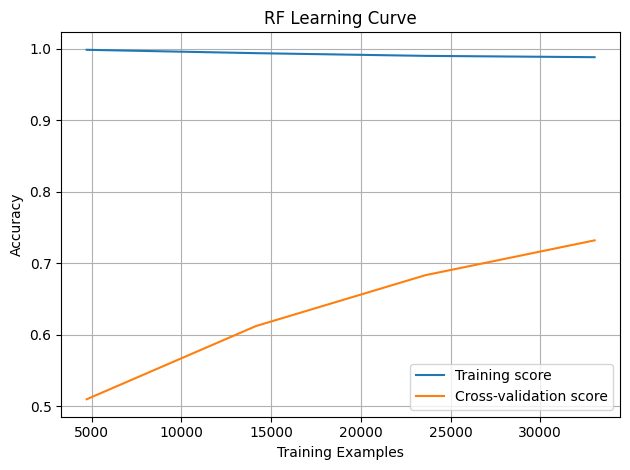

In [148]:
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, 
    cv=2,  # Minimal CV folds
    scoring='accuracy', 
    train_sizes=[0.1, 0.3, 0.5, 0.7],  # Fewer, specific sizes
    n_jobs=1  # Single core
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean= np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.title("RF Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

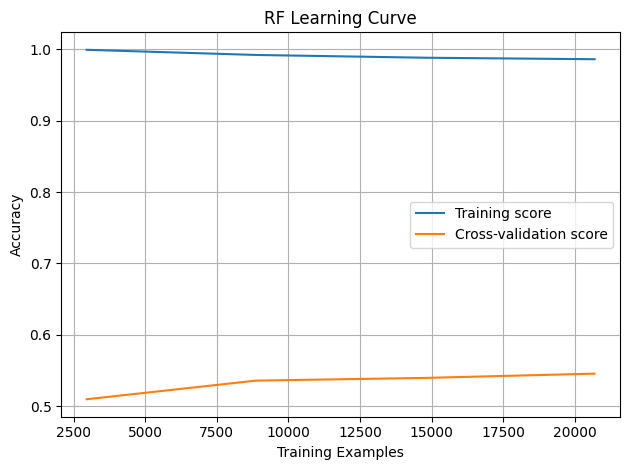

In [158]:
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, 
    cv=2,  # Minimal CV folds
    scoring='accuracy', 
    train_sizes=[0.1, 0.3, 0.5, 0.7],  # Fewer, specific sizes
    n_jobs=1  # Single core
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean= np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.title("RF Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
param_range = [3, 5, 7, 10, 12, 15, 20, 25]
    
train_scores, val_scores = validation_curve(
    rf,
    X_train, y_train,
    param_name='max_depth',
    param_range=param_range,
    cv=5,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(param_range, val_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve: Max Depth vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()